<a href="https://colab.research.google.com/github/treefriend/-NLP-Pre_requisite/blob/master/Megatron_LM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

This notebook contains a simulation of three different pipeline schedules, GPipe, PipeDream ("1F1B"), and 1F1B with interleaved layers ("Interleaved"). The notebook follows the description from the "Efficient Large-Scale Language Model Training on GPU Clusters Using Megatron-LM" paper (2021) (https://arxiv.org/abs/2104.04473). The layout of the notebook is as follows.

0. **Functions**: Defines the worker class and scheduler function.
* *Worker class* is equivalent to one GPU used in the pipeline parallelism.
* *Scheduler class* is responsible for facilitating the communication among the Workers.

1. **GPipe**: This section simulates the default pipeline parallel schedule with varying number of microbatches and workers.

2. **1F1B**: This section simulates the 1F1B pipeline schedule with varying number of microbatches and workers.

3. **Interleaved**: This section simulates the interleaved schedule with varying number of microbatches and workers. This section demonstrates how the new pipeline schedule proposed by the paper is more time and memory efficient than other approaches.

## 0. Functions

There are two main classes and one function for simulating the pipeline parallelism.

1. Scheduler: Coordinates receiving and sending microbatches among workers.
2. Worker (=GPUs): Keeps track of the microbatches to be processed and run a forward/backward pass on them at each timestep.
3. run_schedule: Runs the specified pipeline schedule for one batch consisting of many microbatches.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
class Scheduler:

    def __init__(self, method, workers, layer_to_worker, num_microbatch):
        """Scheduler class coordinates sending and receiving processed microbatch among workers and decide when to initiate the next forward/backward pass.
        1. method: gpipe/1f1b/interleaved. The schedule differs by method.
        2. workers: dictionary mapping worker id to worker object
        3. num_workers: total number of workers.
        4. layer_to_worker: dictionary mapping the model layer to each worker.
        5. max_layer: the final model layer

        6. in_flight_batch: a set of microbatches whose activation is kept in memory to be used during backward pass.
        7. remaining_forward: a list of microbatches to be processed for forward pass
        8. remaining_backward: a list of microbatches to be processed for backward pass

        9. memory_per_timestep: a list to track total memory accumulated per timestep
        10. gpu_idle_per_timestep: a list to track GPU idle time per timestep
        """

        self.method = method
        self.workers = workers
        self.num_workers = len(workers.keys())
        self.layer_to_worker = layer_to_worker
        self.max_layer = max(layer_to_worker.keys())

        self.in_flight_batch = set()
        self.remaining_forward = [i for i in range(num_microbatch)]
        self.remaining_backward = [i for i in range(num_microbatch)]

        self.memory_per_timestep = []
        self.gpu_idle_per_timestep = []
        self.microbatch_per_timestemp = {w: [] for w in self.workers}
        self.communication_per_timestep = []

    def send_work_to_next_device(self, prev_work):
        """Receives the processed microbatch and pass to the next device responsible for processing it.
        """

        direction = prev_work['work'][0] # 'f' if forward, 'b' if backward
        microbatch = prev_work['work'][1:]
        length = prev_work['length']
        prev_stage = prev_work['stage']
        prev_worker = self.layer_to_worker[prev_stage]
        next_worker = None

        if direction == 'f':
            # add the work for backward pass on the microbatch immediately
            if prev_stage == self.max_layer:
                # print("Max layer forward!")
                if self.method in ['1f1b','interleaved']:
                    next_worker = prev_worker
                    self.workers[prev_worker].add_work(work='b'+microbatch, length=2, stage=self.max_layer, priority=True)

            elif prev_stage != self.max_layer:
                next_worker = self.layer_to_worker[prev_stage + 1]
                if prev_worker == next_worker:
                    self.workers[next_worker].add_work(work=prev_work['work'], length=length, stage=prev_stage+1, priority=True)
                else:
                    self.workers[next_worker].add_work(work=prev_work['work'], length=length, stage=prev_stage+1)

        elif direction == 'b':
            if prev_stage == 1:
                pass
            elif prev_stage != 1:
                next_worker = self.layer_to_worker[prev_stage - 1]
                if prev_worker == next_worker:
                    self.workers[next_worker].add_work(work=prev_work['work'], length=length, stage=prev_stage-1, priority=True)
                else:
                    self.workers[next_worker].add_work(work=prev_work['work'], length=length, stage=prev_stage-1)

        return next_worker

    def initiate_pass_on_microbatch(self):
        """Checks if forward pass / backward pass should be initiated (memory permitting).
        """

        first_worker = self.layer_to_worker[1]
        last_worker = self.layer_to_worker[self.max_layer]

        if self.method == 'gpipe':
            # add the work for the backward pass if the forward is done
            if self.workers[first_worker].has_work() == False and len(self.remaining_forward) > 0:
                # print(f"Initiating a new back {self.remaining_forward[0]}")
                self.workers[first_worker].add_work(work = 'f' + str(self.remaining_forward.pop(0)), length = 1, stage = 1)

            elif self.workers[last_worker].has_work() == False and len(self.remaining_forward) == 0 and len(self.remaining_backward) > 0:
                self.workers[last_worker].add_work(work = 'b' + str(self.remaining_backward.pop(0)), length=2, stage=self.max_layer)

        elif self.method in ['1f1b','interleaved']:
            # if there's remaining forward microbatch and the first worker is idle
            if self.workers[first_worker].has_work()==False and len(self.remaining_forward) > 0:
                # 1f1b restricts # in-flight microbatches
                if self.method == 'interleaved' or (self.method == '1f1b' and len(self.in_flight_batch) + 1 <= self.num_workers):
                    self.workers[first_worker].add_work(work = 'f' + str(self.remaining_forward.pop(0)), length = 1, stage = 1)


    def update_in_flight_batch(self, work):
        """Keeps track of how many microbatches are in-flight.
        1F1B schedule does not allow the in-flight batch size to be more than the # workers
        """

        direction = work['work'][0]
        microbatch_num = work['work'][1:]

        if direction == 'f' and work['stage'] == 1:
            self.in_flight_batch.add(microbatch_num)

        elif direction == 'b' and work['stage'] == 1: # self.max_layer
            self.in_flight_batch.remove(microbatch_num)


    def is_done(self):
        """Checks if all microbatches have been processed (forward + backward).
        """

        if len([w for w in self.workers if self.workers[w].has_work()]) > 0:
            return False
        else:
            return True


    def tick(self):
        """Tracks the work that happens in one timestep.
        Workers process the microbatch in their queue, and the scheduler sends the processed microbatches to the next worker.
        """

        queue = [w for w in self.workers if self.workers[w].has_work()]
        idle = [w for w in self.workers if self.workers[w].has_work()==False]
        self.gpu_idle_per_timestep.append(len(idle))
        communication_num = 0

        while len(queue) > 0:
            worker_num = queue.pop(0)
            if self.workers[worker_num].has_work():
                processed_work = self.workers[worker_num].do_work()
                self.microbatch_per_timestemp[worker_num].append(processed_work['work'])
                if processed_work['done']:
                    next_worker = self.send_work_to_next_device(processed_work)
                    if next_worker != worker_num and next_worker is not None:
                        communication_num += 1
                    self.update_in_flight_batch(processed_work)

        self.communication_per_timestep.append(communication_num)
        for w in idle:
            self.microbatch_per_timestemp[w].append('..')

        timestep_memory = 0
        for w in self.workers:
            timestep_memory += self.workers[w].memory
        self.memory_per_timestep.append(timestep_memory)


In [4]:
class Worker:

    def __init__(self, device_num, method):
        """Each worker keeps track of the following states:

        1. work: a list of microbatches to process, in the order of priority
        2. device_num: the worker's unique identifier in integer
        3. memory: the total activation memory being kept for backpropagation (1 microbatch per layer = 1 unit of memory)
        """

        self.work = []
        self.device_num = device_num
        self.memory = 0


    def add_work(self, work, length, stage, priority=False):
        """Add work (microbatch) to the worker's work queue
        """

        if priority:
            self.work = [{'work': work, 'length': length, 'worked_on': 0, 'stage': stage, 'done': False}] + self.work
        else:
            self.work.append({'work': work, 'length': length, 'worked_on': 0, 'stage': stage, 'done': False})


    def has_work(self):
        """Checks if the worker microbatch in its queue
        """

        if len(self.work) > 0:
            return True
        else:
            return False


    def do_work(self):
        """The worker processes the microbatch at timestep t
        """

        curr_work = self.work.pop(0)
        curr_work['worked_on'] += 1
        # microbatch_num = curr_work['work'][1:]
        direction = curr_work['work'][0]
        curr_work['done'] = True if curr_work['worked_on'] == curr_work['length'] else False

        # 1. if the work is done, accumulate/release activation memory
        if curr_work['done']:
            # print(f"worker {self.device_num} finished a job {curr_work}")

            # i. increment/decrement activation
            if direction == 'f':
                self.memory += 1 # accumulate activation
            elif direction == 'b':
                self.memory -= 1 # release activation

        # 2. if the work is not done, continue
        elif not curr_work['done']:
            self.work = [curr_work] + self.work

        return curr_work

In [5]:
def run_schedule(method, num_microbatch, num_worker, layer_to_worker):
    """Runs the pipeline schedule.
    """

    workers = {i: Worker(i, method) for i in range(num_worker)}

    s = Scheduler(method=method, num_microbatch=num_microbatch, workers=workers, layer_to_worker=layer_to_worker)

    time_elapsed = 0
    done = False
    s.initiate_pass_on_microbatch()
    while not done:
        # print(">>> TIME: ", time_elapsed)
        s.tick()

        time_elapsed += 1
        s.initiate_pass_on_microbatch()
        done = s.is_done()

    print(f"Total time elapsed: {time_elapsed}")

    return s.memory_per_timestep, s.gpu_idle_per_timestep, s.microbatch_per_timestemp, s.communication_per_timestep

In [6]:
def visualize_schedule(device_log):

    for d in device_log:
      print(' '.join(device_log[d]))


## 1. GPipe (default)

This section implements the default pipeline schedule shown below. GPipe splits the model into stages and processes multiple microbatches sequentially.

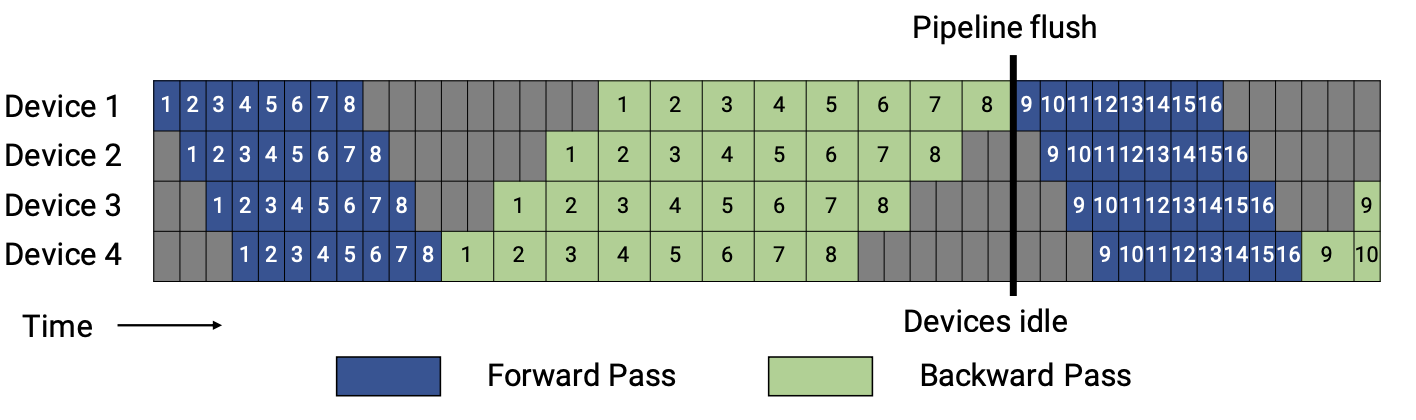


In [7]:
gpipe_worker_to_layer = {
    0: [1,2],
    1: [3,4],
    2: [5,6],
    3: [7,8]
}

gpipe_layer_to_worker = {}
for w in gpipe_worker_to_layer:
    for l in gpipe_worker_to_layer[w]:
        gpipe_layer_to_worker[l] = w

gpipe_memory, gpipe_idle, gpipe_microbatch, gpipe_communication = run_schedule(method='gpipe', num_microbatch=8, num_worker=4, layer_to_worker=gpipe_layer_to_worker)
visualize_schedule(gpipe_microbatch)

Total time elapsed: 66
f0 f0 f1 f1 f2 f2 f3 f3 f4 f4 f5 f5 f6 f6 f7 f7 .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. b0 b0 b0 b0 b1 b1 b1 b1 b2 b2 b2 b2 b3 b3 b3 b3 b4 b4 b4 b4 b5 b5 b5 b5 b6 b6 b6 b6 b7 b7 b7 b7
.. .. f0 f0 f1 f1 f2 f2 f3 f3 f4 f4 f5 f5 f6 f6 f7 f7 .. .. .. .. .. .. .. .. .. .. .. .. b0 b0 b0 b0 b1 b1 b1 b1 b2 b2 b2 b2 b3 b3 b3 b3 b4 b4 b4 b4 b5 b5 b5 b5 b6 b6 b6 b6 b7 b7 b7 b7 .. .. .. ..
.. .. .. .. f0 f0 f1 f1 f2 f2 f3 f3 f4 f4 f5 f5 f6 f6 f7 f7 .. .. .. .. .. .. b0 b0 b0 b0 b1 b1 b1 b1 b2 b2 b2 b2 b3 b3 b3 b3 b4 b4 b4 b4 b5 b5 b5 b5 b6 b6 b6 b6 b7 b7 b7 b7 .. .. .. .. .. .. .. ..
.. .. .. .. .. .. f0 f0 f1 f1 f2 f2 f3 f3 f4 f4 f5 f5 f6 f6 f7 f7 b0 b0 b0 b0 b1 b1 b1 b1 b2 b2 b2 b2 b3 b3 b3 b3 b4 b4 b4 b4 b5 b5 b5 b5 b6 b6 b6 b6 b7 b7 b7 b7 .. .. .. .. .. .. .. .. .. .. .. ..


In [8]:
gpipe_worker_to_layer = {
    0: [1],
    1: [2],
    2: [3],
    3: [4],
    4: [5],
    5: [6],
    6: [7],
    7: [8],
}

gpipe_layer_to_worker = {}
for w in gpipe_worker_to_layer:
    for l in gpipe_worker_to_layer[w]:
        gpipe_layer_to_worker[l] = w


gpipe_memory_w, gpipe_idle_w, gpipe_microbatch_w, gpipe_communication_w = run_schedule(method='gpipe', num_microbatch=8, num_worker=8, layer_to_worker=gpipe_layer_to_worker)

visualize_schedule(gpipe_microbatch_w)

Total time elapsed: 45
f0 f1 f2 f3 f4 f5 f6 f7 .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. b0 b0 b1 b1 b2 b2 b3 b3 b4 b4 b5 b5 b6 b6 b7 b7
.. f0 f1 f2 f3 f4 f5 f6 f7 .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. b0 b0 b1 b1 b2 b2 b3 b3 b4 b4 b5 b5 b6 b6 b7 b7 .. ..
.. .. f0 f1 f2 f3 f4 f5 f6 f7 .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. b0 b0 b1 b1 b2 b2 b3 b3 b4 b4 b5 b5 b6 b6 b7 b7 .. .. .. ..
.. .. .. f0 f1 f2 f3 f4 f5 f6 f7 .. .. .. .. .. .. .. .. .. .. .. .. b0 b0 b1 b1 b2 b2 b3 b3 b4 b4 b5 b5 b6 b6 b7 b7 .. .. .. .. .. ..
.. .. .. .. f0 f1 f2 f3 f4 f5 f6 f7 .. .. .. .. .. .. .. .. .. b0 b0 b1 b1 b2 b2 b3 b3 b4 b4 b5 b5 b6 b6 b7 b7 .. .. .. .. .. .. .. ..
.. .. .. .. .. f0 f1 f2 f3 f4 f5 f6 f7 .. .. .. .. .. .. b0 b0 b1 b1 b2 b2 b3 b3 b4 b4 b5 b5 b6 b6 b7 b7 .. .. .. .. .. .. .. .. .. ..
.. .. .. .. .. .. f0 f1 f2 f3 f4 f5 f6 f7 .. .. .. b0 b0 b1 b1 b2 b2 b3 b3 b4 b4 b5 b5 b6 b6 b7 b7 .. .. .. .. .. .. .. .. .. .. .. ..
.. .. .. .. .. .. .. f0 f1 f2 f3

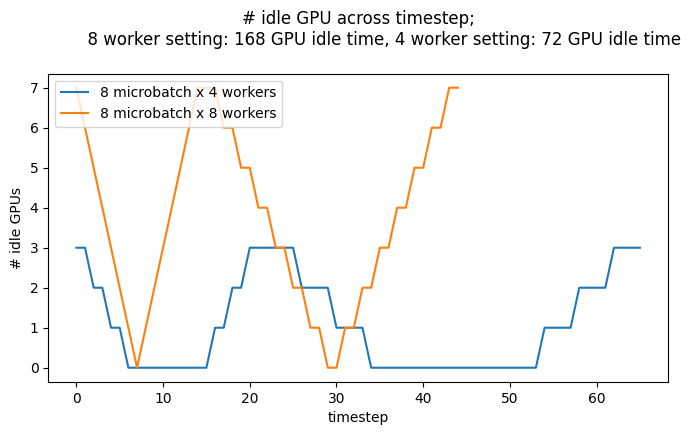

In [9]:
plt.subplots(figsize=(8,4))
plt.plot(gpipe_idle, label = '8 microbatch x 4 workers')
plt.plot(gpipe_idle_w, label = '8 microbatch x 8 workers')
plt.legend(loc='upper left')
plt.title(f"""# idle GPU across timestep;
          8 worker setting: {sum(gpipe_idle_w)} GPU idle time, 4 worker setting: {sum(gpipe_idle)} GPU idle time
          """)
plt.ylabel("# idle GPUs")
plt.xlabel("timestep")
plt.show()
print(f"")

Although using more workers process the batch faster, the GPU idle time goes up.

## 2. 1F1B vs. Interleaved

This section implements the 1F1B pipeline schedule and the interleaved schedule.

The **1F1B pipeline schedule** takes the same amount time as the default pipeline schedule, but it is more memory efficient. The **interleaved schedule** uses adopts the 1F1B pipeline schedule, but assigns the non-consecutive model layers to devices to reduce the pipeline bubble size.

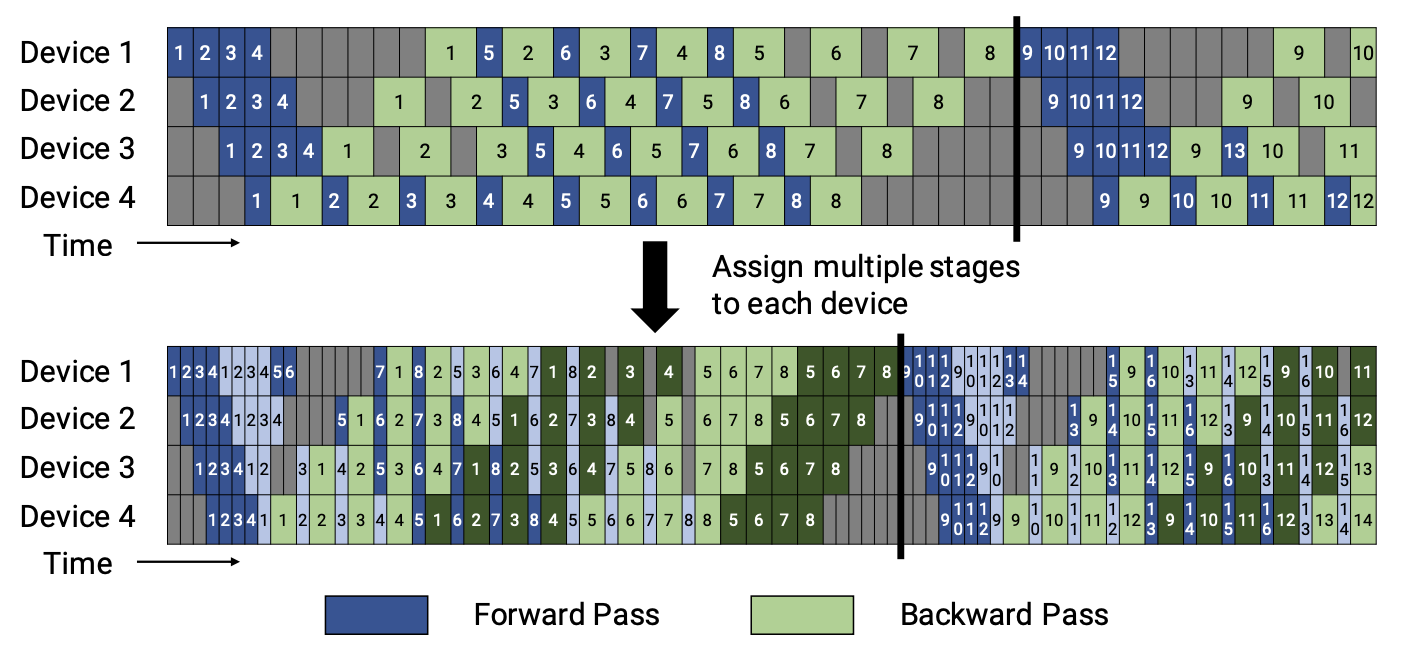

## 2.a 1F1B pipeline schedule

In [10]:
onefoneb_worker_to_layer = {
    0: [1,2],
    1: [3,4],
    2: [5,6],
    3: [7,8]
}

onefoneb_layer_to_worker = {}
for w in onefoneb_worker_to_layer:
    for l in onefoneb_worker_to_layer[w]:
        onefoneb_layer_to_worker[l] = w

onefoneb_memory, onefoneb_idle, onefoneb_microbatch, onefoneb_communication = run_schedule(method='1f1b', num_microbatch=8, num_worker=4, layer_to_worker=onefoneb_layer_to_worker)
visualize_schedule(onefoneb_microbatch)

Total time elapsed: 66
f0 f0 f1 f1 f2 f2 f3 f3 .. .. .. .. .. .. .. .. .. .. .. .. b0 b0 b0 b0 f4 f4 b1 b1 b1 b1 f5 f5 b2 b2 b2 b2 f6 f6 b3 b3 b3 b3 f7 f7 b4 b4 b4 b4 .. .. b5 b5 b5 b5 .. .. b6 b6 b6 b6 .. .. b7 b7 b7 b7
.. .. f0 f0 f1 f1 f2 f2 f3 f3 .. .. .. .. .. .. b0 b0 b0 b0 .. .. b1 b1 b1 b1 f4 f4 b2 b2 b2 b2 f5 f5 b3 b3 b3 b3 f6 f6 b4 b4 b4 b4 f7 f7 b5 b5 b5 b5 .. .. b6 b6 b6 b6 .. .. b7 b7 b7 b7 .. .. .. ..
.. .. .. .. f0 f0 f1 f1 f2 f2 f3 f3 b0 b0 b0 b0 .. .. b1 b1 b1 b1 .. .. b2 b2 b2 b2 f4 f4 b3 b3 b3 b3 f5 f5 b4 b4 b4 b4 f6 f6 b5 b5 b5 b5 f7 f7 b6 b6 b6 b6 .. .. b7 b7 b7 b7 .. .. .. .. .. .. .. ..
.. .. .. .. .. .. f0 f0 b0 b0 b0 b0 f1 f1 b1 b1 b1 b1 f2 f2 b2 b2 b2 b2 f3 f3 b3 b3 b3 b3 f4 f4 b4 b4 b4 b4 f5 f5 b5 b5 b5 b5 f6 f6 b6 b6 b6 b6 f7 f7 b7 b7 b7 b7 .. .. .. .. .. .. .. .. .. .. .. ..


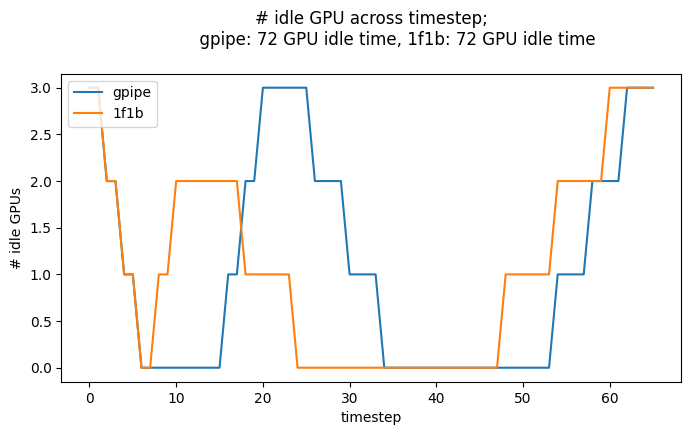

In [11]:
plt.subplots(figsize=(8,4))
plt.plot(gpipe_idle, label = 'gpipe')
plt.plot(onefoneb_idle, label = '1f1b')
plt.legend(loc='upper left')
plt.title(f"""# idle GPU across timestep;
          gpipe: {sum(gpipe_idle)} GPU idle time, 1f1b: {sum(gpipe_idle)} GPU idle time
          """)
plt.ylabel("# idle GPUs")
plt.xlabel("timestep")
plt.show()
print(f"")

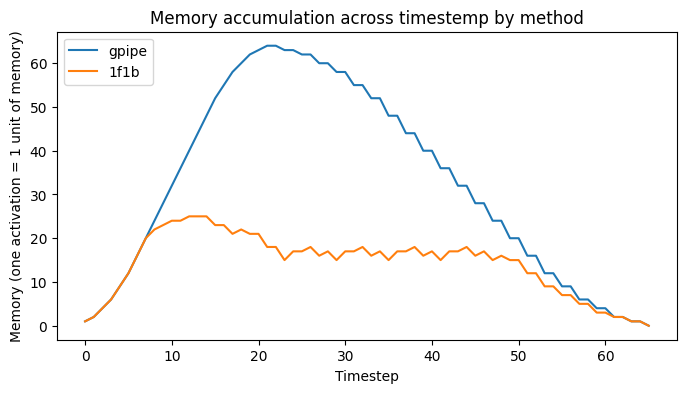

In [12]:
plt.subplots(figsize=(8,4))
plt.plot(np.arange(0,len(gpipe_memory)), gpipe_memory, label = 'gpipe')
plt.plot(np.arange(0,len(onefoneb_memory)), onefoneb_memory, label='1f1b')
plt.legend(loc='upper left')
plt.xlabel("Timestep")
plt.ylabel("Memory (one activation = 1 unit of memory)")
plt.title("Memory accumulation across timestemp by method")
plt.show()

The benefit of 1F1B schedule is its memory efficiency compared to the GPipe method. The total # of idle GPUs for the whole run is the same.

## 2.b Interleaved pipeline schedule

In [13]:
interleaved_worker_to_layer = {
    0: [1,5],
    1: [2,6],
    2: [3,7],
    3: [4,8]
}

interleaved_layer_to_worker = {}
for w in interleaved_worker_to_layer:
    for l in interleaved_worker_to_layer[w]:
        interleaved_layer_to_worker[l] = w

interleaved_memory, interleaved_idle, interleaved_microbatch, interleaved_communication = run_schedule(method='interleaved', num_microbatch=8, num_worker=4, layer_to_worker=interleaved_layer_to_worker)
visualize_schedule(interleaved_microbatch)


Total time elapsed: 57
f0 f1 f2 f3 f0 f1 f2 f3 f4 f5 f6 f7 .. .. .. b0 b0 .. .. .. b1 b1 f4 f5 b2 b2 f6 f7 b3 b3 .. b0 b0 b1 b1 .. .. b2 b2 b4 b4 b5 b5 b3 b3 b6 b6 b7 b7 b4 b4 b5 b5 b6 b6 b7 b7
.. f0 f1 f2 f3 f0 f1 f2 f3 f4 f5 f6 f7 b0 b0 .. .. .. b1 b1 b2 b2 b3 b3 f4 f5 .. f6 f7 b0 b0 b1 b1 .. .. b2 b2 b4 b4 b5 b5 b3 b3 b6 b6 b7 b7 b4 b4 b5 b5 b6 b6 b7 b7 .. ..
.. .. f0 f1 f2 f3 f0 f1 f2 f3 f4 b0 b0 f5 f6 f7 b1 b1 b2 b2 b3 b3 .. .. .. f4 b0 b0 f5 b1 b1 f6 f7 b2 b2 b4 b4 b5 b5 b3 b3 b6 b6 b7 b7 b4 b4 b5 b5 b6 b6 b7 b7 .. .. .. ..
.. .. .. f0 f1 f2 f3 f0 b0 b0 f1 b1 b1 f2 b2 b2 f3 b3 b3 f4 f5 f6 f7 b0 b0 b1 b1 b2 b2 f4 b4 b4 f5 b5 b5 b3 b3 f6 b6 b6 f7 b7 b7 b4 b4 b5 b5 b6 b6 b7 b7 .. .. .. .. .. ..


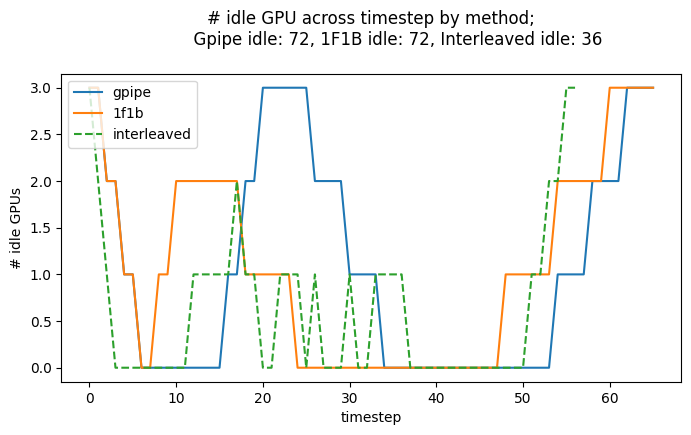

In [14]:
plt.subplots(figsize=(8,4))
plt.plot(np.arange(0,len(gpipe_idle)), gpipe_idle, label = 'gpipe')
plt.plot(np.arange(0,len(onefoneb_idle)), onefoneb_idle, label='1f1b')
plt.plot(np.arange(0,len(interleaved_idle)), interleaved_idle, label = 'interleaved', linestyle='--')
plt.legend(loc='upper left')
plt.title(f"""# idle GPU across timestep by method;
          Gpipe idle: {sum(gpipe_idle)}, 1F1B idle: {sum(onefoneb_idle)}, Interleaved idle: {sum(interleaved_idle)}
          """)
plt.ylabel("# idle GPUs")
plt.xlabel("timestep")
plt.show()
print(f"")

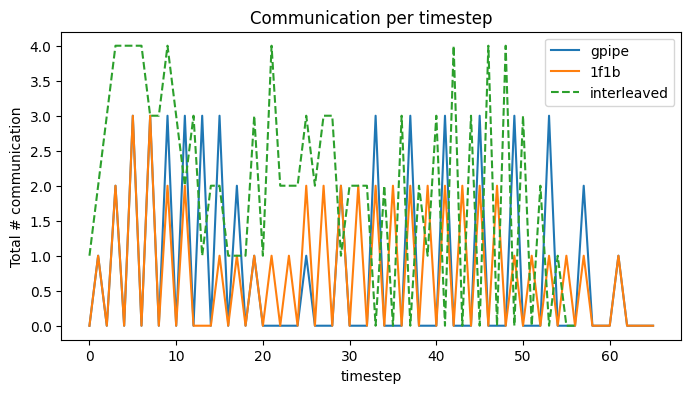

In [15]:
plt.subplots(figsize=(8,4))
plt.plot(gpipe_communication, label = 'gpipe')
plt.plot(onefoneb_communication, label = '1f1b')
plt.plot(interleaved_communication, label = 'interleaved', linestyle='--')
plt.legend()
plt.title(f"""Communication per timestep""")
plt.ylabel("Total # communication")
plt.xlabel("timestep")
plt.show()